In [42]:
import pandas as pd

file_path = '/content/Amazon Sale Report.csv'
data = pd.read_csv(file_path)

print("Dataset Overview:")
print(data.info())

missing_values = data.isnull().sum()
print("\nMissing Values by Column:")
print(missing_values)

for column in data.columns:
    if data[column].isnull().sum() > 0:
        if data[column].dtype in ['float64', 'int64']:

            data[column].fillna(data[column].mean(), inplace=True)
        elif data[column].dtype == 'object':

            data[column].fillna(data[column].mode()[0], inplace=True)

print("\nMissing Values After Imputation:")
print(data.isnull().sum())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  float64
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      128975 non-null  object 
 13  Qty                 128975 non-null  float64
 14  currency            128975 non-null  object 
 15  Amount          

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

data_standardized = data.copy()
data_standardized[numerical_columns] = standard_scaler.fit_transform(data[numerical_columns])


data_normalized = data.copy()
data_normalized[numerical_columns] = min_max_scaler.fit_transform(data[numerical_columns])


standardized_file_path = '/content/Amazon Sale Report.csv'
normalized_file_path = '/content/Amazon Sale Report.csv'

data_standardized.to_csv(standardized_file_path, index=False)
data_normalized.to_csv(normalized_file_path, index=False)

print(f"\nStandardized dataset saved to {standardized_file_path}")
print(f"Normalized dataset saved to {normalized_file_path}")



Standardized dataset saved to /content/Amazon Sale Report.csv
Normalized dataset saved to /content/Amazon Sale Report.csv


In [40]:
import numpy as np
from scipy.signal import savgol_filter


numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
feature_to_modify = numerical_columns[0]
print(f"Feature selected for noise injection: {feature_to_modify}")


np.random.seed(42)
noise = np.random.normal(0, 0.1, size=data[feature_to_modify].shape)
data_noisy = data.copy()
data_noisy[feature_to_modify] += noise

data_smoothed_rolling = data_noisy.copy()
data_smoothed_rolling[feature_to_modify] = data_noisy[feature_to_modify].rolling(window=5, center=True).mean()


data_smoothed_savgol = data_noisy.copy()
data_smoothed_savgol[feature_to_modify] = savgol_filter(data_noisy[feature_to_modify], window_length=5, polyorder=2)

noisy_file_path = '/content/Amazon Sale Report.csv'
smoothed_rolling_file_path = '/content/Amazon Sale Report.csv'
smoothed_savgol_file_path = '/content/Amazon Sale Report.csv'

data_noisy.to_csv(noisy_file_path, index=False)
data_smoothed_rolling.to_csv(smoothed_rolling_file_path, index=False)
data_smoothed_savgol.to_csv(smoothed_savgol_file_path, index=False)

print(f"\nNoisy dataset saved to {noisy_file_path}")
print(f"Dataset smoothed with rolling average saved to {smoothed_rolling_file_path}")
print(f"Dataset smoothed with Savitzky-Golay filter saved to {smoothed_savgol_file_path}")

Feature selected for noise injection: index

Noisy dataset saved to /content/Amazon Sale Report.csv
Dataset smoothed with rolling average saved to /content/Amazon Sale Report.csv
Dataset smoothed with Savitzky-Golay filter saved to /content/Amazon Sale Report.csv


In [39]:
from scipy.stats import zscore


threshold = 3
outliers_removed_data = data.copy()
outliers_capped_data = data.copy()


for column in numerical_columns:

    z_scores = zscore(data[column].dropna())
    abs_z_scores = np.abs(z_scores)


    outliers = abs_z_scores > threshold
    print(f"Column: {column}")
    print(f"Number of outliers detected: {outliers.sum()}")


    outliers_removed_data = outliers_removed_data.loc[~outliers, :]


    lower_bound = data[column].mean() - threshold * data[column].std()
    upper_bound = data[column].mean() + threshold * data[column].std()
    outliers_capped_data[column] = np.where(
        outliers,
        np.clip(data[column], lower_bound, upper_bound),
        data[column]
    )


outliers_removed_file_path = '/content/Amazon Sale Report.csv'
outliers_capped_file_path = '/content/Amazon Sale Report.csv'

outliers_removed_data.to_csv(outliers_removed_file_path, index=False)
outliers_capped_data.to_csv(outliers_capped_file_path, index=False)

print(f"\nDataset with outliers removed saved to {outliers_removed_file_path}")
print(f"Dataset with outliers capped saved to {outliers_capped_file_path}")


Column: index
Number of outliers detected: 0
Column: Qty
Number of outliers detected: 388
Column: Amount
Number of outliers detected: 946
Column: ship-postal-code
Number of outliers detected: 0

Dataset with outliers removed saved to /content/Amazon Sale Report.csv
Dataset with outliers capped saved to /content/Amazon Sale Report.csv


Correlation with Target:
 index               0.046099
Qty                 0.044359
ship-postal-code   -0.036988
dtype: float64


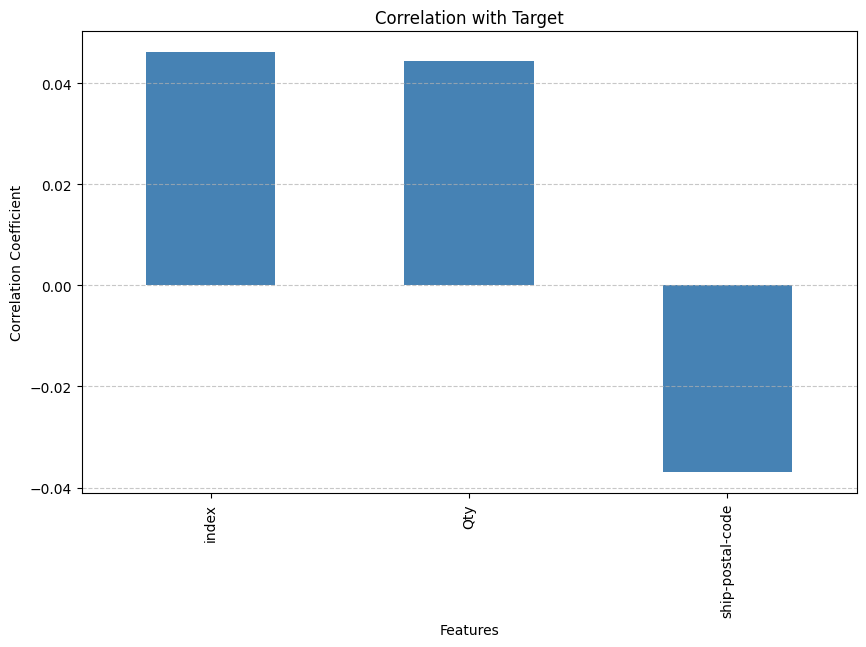


Mutual Information Scores:
 index               0.460989
Qty                 0.318417
ship-postal-code    0.114397
dtype: float64


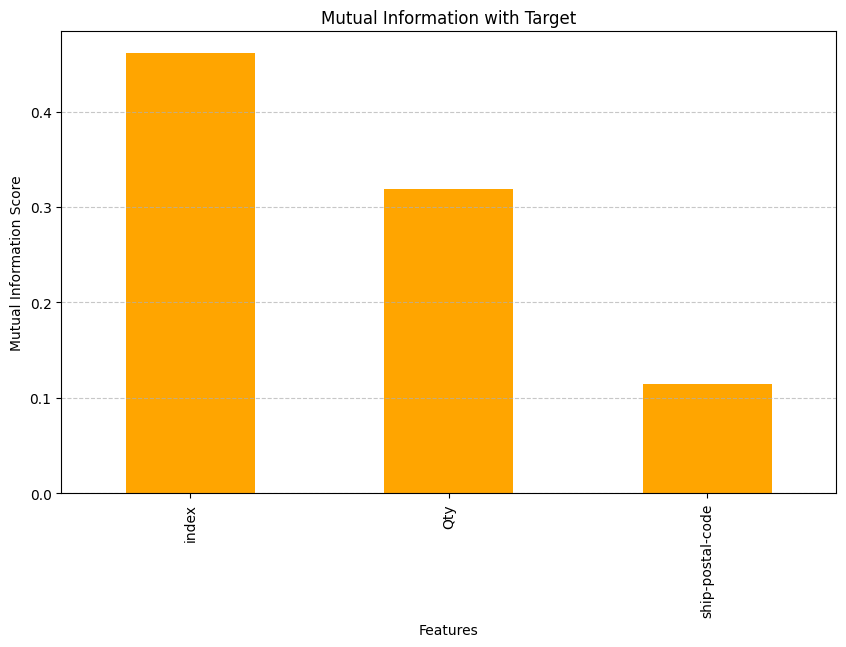


Top 5 Features by Correlation:
 index               0.046099
Qty                 0.044359
ship-postal-code   -0.036988
dtype: float64

Top 5 Features by Mutual Information:
 index               0.460989
Qty                 0.318417
ship-postal-code    0.114397
dtype: float64


In [38]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import matplotlib.pyplot as plt


target_column = 'Amount'
features = data.drop(columns=[target_column])
target = data[target_column]


numerical_features = features.select_dtypes(include=['float64', 'int64'])


def correlation_with_target(X, y):
    correlation = X.corrwith(y)
    print("Correlation with Target:\n", correlation)


    plt.figure(figsize=(10, 6))
    correlation.sort_values(ascending=False).plot(kind='bar', color='steelblue')
    plt.title('Correlation with Target')
    plt.ylabel('Correlation Coefficient')
    plt.xlabel('Features')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return correlation

correlation_scores = correlation_with_target(numerical_features, target)


def mutual_information_with_target(X, y):
    mutual_info = mutual_info_regression(X, y)
    mutual_info_series = pd.Series(mutual_info, index=X.columns)
    print("\nMutual Information Scores:\n", mutual_info_series)


    plt.figure(figsize=(10, 6))
    mutual_info_series.sort_values(ascending=False).plot(kind='bar', color='orange')
    plt.title('Mutual Information with Target')
    plt.ylabel('Mutual Information Score')
    plt.xlabel('Features')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return mutual_info_series

mutual_info_scores = mutual_information_with_target(numerical_features, target)

print("\nTop 5 Features by Correlation:\n", correlation_scores.nlargest(5))
print("\nTop 5 Features by Mutual Information:\n", mutual_info_scores.nlargest(5))
